### Лаборатоная работа №2. Вячеслав Денисов.
#### Полиномы Чебышева. Метод итераций по подоблостям. N = 4.

In [21]:
import numpy as np
from matplotlib import pyplot as plt
import sympy as sympy
from sympy import diff
import time

#### Полиномы Чебышева

In [22]:
def T(n, x):
    if n == 0:
        return 1
    elif n == 1:
        return x
    else:
        return 2 * x * T(n - 1, x) - T(n - 2, x)
    
def cheb_polinome(c, x):
    return sum([c[i] * T(i, x) for i in range(len(c))])

#### Точное решение

In [23]:
def w_ex(x):
    return x ** 2 * (1 - x) ** 2 * np.exp(x)

#### 4-я производная

In [24]:
def f(x):
    return np.exp(x) * (32 * x + 49 * x ** 2 + 14 * x ** 3 + x ** 4 - 12)

#### Абсолютная ошибка

In [25]:
def ea(y_by_wex, y):
    return max([np.abs(y_by_wex[i] - y[i])
                for i in range(len(y))])

#### Относительная ошибка

In [26]:
def er(y_by_wex, y):
    return ea(y_by_wex, y)/max(y_by_wex)

#### Число обусловленности

In [27]:
def mu(A):
    return np.linalg.cond(A)

In [28]:
#Chebyshev polynoms and their diff
def Chebishev(point, n):
    x = sympy.Symbol('x')
    v  = sympy.chebyshevt(n, x)
    return v.subs(x,point)

def Chebishev_dx(point, n):
    x = sympy.Symbol('x')
    v  = sympy.chebyshevt(n, x)
    v = diff(v,x)
    return v.subs(x,point)

def Chebishev_d2x(point, n):
    x = sympy.Symbol('x')
    v  = sympy.chebyshevt(n, x)
    v = diff(v,x,2)
    return v.subs(x,point)   

def Chebishev_d3x(point, n):
    x = sympy.Symbol('x')
    v  = sympy.chebyshevt(n, x)
    v = diff(v,x,3)
    return v.subs(x,point) 

def Chebishev_d4x(point, n):
    x = sympy.Symbol('x')
    v  = sympy.chebyshevt(n, x)
    v = diff(v,x,4)
    return v.subs(x,point) 

#D4 of the solution
def Func(x_point):
    x = sympy.Symbol('x')
    f= x**2*(1-x)**2*sympy.exp(x)
    f = diff(f,x,4)
    #sympy.pprint(dx)
    return f.subs(x,x_point) 

#F of the solution
def Acc_Func(x_point):
    x = sympy.Symbol('x')
    f  = x**2*(1-x)**2*sympy.exp(x)
    return f.subs(x,x_point) 

In [29]:
def coll_dot():
    colloc_mas = np.zeros([N+1]) 
    for m in range (N+1):
        colloc_mas[m] = np.cos((2*(m+1)-1)*np.pi/(2*(N+1)))
    colloc_mas = np.flipud(colloc_mas)
    return colloc_mas

In [30]:
#Left c_vector
def b_left(m, dots, c_old, h):
    b = np.zeros(N+5)
    
    for j in range(N+1):
        for i in range (m):
            b[j] = h**4*Func(h*dots[j] + h*(2*i+1))
            #print(b[j])
            
    for j in range (N+1):
        b[N+1] = b[N+1] + c_old[j]*(Chebishev(-1,j) + Chebishev_dx(-1,j))
        b[N+2] = b[N+2] + c_old[j]*(Chebishev_d2x(-1,j) + Chebishev_d3x(-1,j))
    return b

def b_mid(m, dots, c_old_1, c_old_2, h):
    b = np.zeros(N+5)
    
    for j in range (N+1):
        b[N+1] = b[N+1] + c_old_1[j]*(Chebishev(1,j) - Chebishev_dx(1,j))
        
        b[N+2] = b[N+2] + c_old_1[j]*(Chebishev_d2x(1,j) - Chebishev_d3x(1,j))
    
    for j in range(N+1):
        for i in range (m):
            b[j] = h**4*Func(h*dots[j] + h*(2*i+1))
            
    for j in range (N+1):
        b[N+3] = b[N+3] + c_old_2[j]*(Chebishev(-1,j) + Chebishev_dx(-1,j))
        b[N+4] = b[N+4] + c_old_2[j]*(Chebishev_d2x(-1,j) + Chebishev_d3x(-1,j))
    return b

def b_right(m_from_k, dots, c_old, h):
    b = np.zeros(N+5)
    
    for j in range (N+1):
        b[N+1] = b[N+1] + c_old[j]*(Chebishev(1,j) - Chebishev_dx(1,j))
        b[N+2] = b[N+2] + c_old[j]*(Chebishev_d2x(1,j) - Chebishev_d3x(1,j))
    
    for j in range(N+1):
        for i in range (m_from_k):
            b[j] = h**4*Func(h*dots[j] + h*(2*i+1))
    return b

#### СЛАУ для ячейки

In [31]:
def slau(K, c1, j):
    N = 4 
    h = 1 / 2 / K
    kc = pow(h, 4)
    b = np.zeros(N + 5)
    x_centers = [(i / K + (i + 1) / K) / 2 for i in range(K)]
    #local_points = np.linspace(-1, 1, N + 3)[1:N + 2]
    local_points = coll_dot()
    
    # Первая матрица
    if j == 0:
        A = [[0,0,0,0,192], [0,0,0,0,192], [0,0,0,0,192], [0,0,0,0,192], [0,0,0,0,192], [1,2,5,10,17], [0,0,4,48,272], [1,-1,1,-1,1], [0,1,-4,9,-16]]
        for i in range(0,5):
            b[i] = kc * f(local_points[i] * h + x_centers[j])
        for i in range (N+1):
            b[5] = b[5] + c1[i][1]*(Chebishev(-1,i) + Chebishev_dx(-1,i))
            b[6] = b[6] + c1[i][1]*(Chebishev_d2x(-1,i) + Chebishev_d3x(-1,i))
            
#         b[5] = c1[0][1] + c1[2][1] + 2 * c1[3][1] + 3 * c1[4][1]
#         b[6] = 2 * c1[2][1] + 12 * c1[4][1]
        b[7] = 0
        b[8] = 0
    # Центральные матрицы
    if j in range (1,K-1):
        A = [[0,0,0,0,192], [0,0,0,0,192], [0,0,0,0,192], [0,0,0,0,192], [0,0,0,0,192], [1,-2,5,-10,17], [0,0,4,-48,272], [1,2,5,10,17], [0,0,4,48,272]]
        for i in range(0,5):
            b[i] = kc * f(local_points[i] * h + x_centers[j])
            
        for i in range (N+1):
            b[5] = b[5] + c1[i][j-1]*(Chebishev(1,i) - Chebishev_dx(1,i))
            b[6] = b[6] + c1[i][j-1]*(Chebishev_d2x(1,i) - Chebishev_d3x(1,i))
            b[7] = b[7] + c1[i][j+1]*(Chebishev(-1,i) + Chebishev_dx(-1,i))
            b[8] = b[8] + c1[i][j+1]*(Chebishev_d2x(-1,i) + Chebishev_d3x(-1,i))
#         b[5] = c1[0][j - 1] - c1[2][j - 1] - 2 * c1[3][j - 1] - 3 * c1[4][j - 1]
#         b[6] = 2 * c1[2][j - 1] - 12 * c1[4][j - 1]
#         b[7] = c1[0][j + 1] - c1[2][j + 1] + 2 * c1[3][j + 1] - 3 * c1[4][j + 1]
#         b[8] = 2 * c1[2][j + 1] + 12 * c1[4][j + 1]
        
    # Последняя матрицы
    if j == K-1:
        A = [[0,0,0,0,192], [0,0,0,0,192], [0,0,0,0,192], [0,0,0,0,192], [0,0,0,0,192], [1,-2,5,-10,17], [0,0,4,-48,272], [1,1,1,1,1], [0,1,4,9,16]]
        for i in range(N+1):
            b[i] = kc * f(local_points[i] * h + x_centers[j])
        
        for i in range (N+1):
            b[5] = b[5] + c1[i][K-2]*(Chebishev(1,i) - Chebishev_dx(1,i))
            #print(c1[i])
            b[6] = b[6] + c1[i][K-2]*(Chebishev_d2x(1,i) - Chebishev_d3x(1,i))
        
        #b[5] = c1[0][K - 2] - c1[2][K - 2] - 2 * c1[3][K - 2] - 3 * c1[4][K - 2]
        #b[6] = 2 * c1[2][K - 2] - 12 * c1[4][K - 2]
        b[7] = 0
        b[8] = 0
    #print(A,b)
    return A, b

#### max|cn+1-cn|

In [32]:
def max1(c1,c2,K):
    N = 4
    m = np.abs(c2[0][0] - c1[0][0])
    for i in range (0, N + 1):
        for j in range (0, K):
            if (np.abs(c2[i][j] - c1[i][j]) > m):
                m = np.abs(c2[i][j] - c1[i][j])
    return m

#### Итерационный метод

In [33]:
def Iter(K):
    N = 4
    M = N + 1
    Niter = 0
    eps = pow(10, -12)
    c2 = np.zeros((M, K))
    for i in range (0, M):
        for j in range (0, K):
            c2[i][j] = 0.4
    c1 = np.zeros((M, K))
    c3 = np.zeros((M, K))
    while (max1(c1,c2,K) >= eps):
        Niter = Niter + 1
        # присваиваем старому решению новое
        c1 = np.copy(c2)
        # для каждой ячейки
        for j in range (0, K):
            c3 = c2
            #формируем СЛАУ
            b = np.zeros(N + 5)
            A = np.zeros((N + 5, N + 1))
            A, b = slau (K, c3, j)
            #решаем её
            c = np.zeros(M)
            Q, R = np.linalg.qr(A)
            c = np.linalg.solve(R, np.dot(Q.transpose(), b)) # Решение системы
            for i in range (0, M):
                c2[i][j] = c[i]

    return c1, c2, Niter

#### Итоговое решение

5
3.213182210922241
10
21.861473083496094
20
173.80900073051453
40
1426.2890665531158
80
11800.550029277802


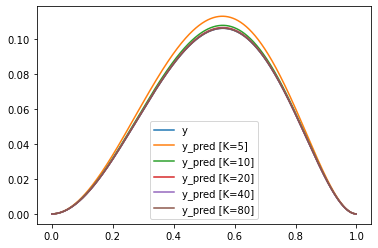

K	Ea	Ea_order	Er	Er_order	Niter	mu(Ab)	mu(Ai)

5	0.006942745265621858	-2.0335711153425695	0.06531860184050953	-2.0335711153425695	78	465.722549148561	792.909196307232

10	0.0016957636708597873	2.0335711153425695	0.015954050997803695	2.0335711153425695	261	465.722549148561	792.909196307232

20	0.0004209615743323569	2.0101746693361973	0.0039604825486142066	2.0101746693361977	1004	465.722549148561	792.909196307232

40	0.00010505941823761578	2.0024830483263765	0.00098841798840559	2.0024830483263765	4032	465.722549148561	792.909196307232

80	2.624839913949184e-05	2.0009041585431406	0.00024694968153777895	2.0009041585431406	16144	465.722549148561	792.909196307232



In [34]:
points_number = 1000
logs = [] # Таблица результатов
X = [i * 0.001 for i in range(points_number)]
# График точного решения
y_by_wex = [w_ex(x) for x in X]
plt.plot(X, y_by_wex, label='y')
N = 4
M = N + 1
for K in [5, 10, 20, 40, 80]:
    t0 = time.time()
    print(K)
    h = 0.5/K
    x_centers = [(i / K + (i + 1) / K) / 2 for i in range(K)]
    c = np.zeros(M * K)
    c1 = np.zeros((M, K))
    c2 = np.zeros((M, K))
    c1, c2, Niter = Iter(K)
    for i in range (0, M * K):
        c[i] = c2[i % (N + 1)][i // (N + 1)]

    y = np.zeros(len(X))
    for i in range(len(X)):
        interval = i // (points_number // K + 1)
        y[i] = cheb_polinome(c[interval * (5):((interval + 1) * (5))],  # коэф-ты c для интервала
                           (X[i] - x_centers[interval]) / h)  # x относительно центра интервала
    
    Ab = np.zeros((N + 5, N + 1))
    b1 = np.zeros(N + 5)
    Ab, b1 = slau(K, c1, 0)
    
    Ai = np.zeros((N + 5, N + 1))
    b2 = np.zeros(N + 5)
    Ai, b2 = slau(K, c1, 1)

    curr_ea = ea(y_by_wex, y)
    curr_er = er(y_by_wex, y)
    if (K != 2):
        plt.plot(X, y, label=f'y_pred [K={str(K)}]')
        logs.append(f"{K}\t"
                    f"{curr_ea}\t"
                    f"{np.log2(prev_ea/curr_ea)}\t"
                    f"{curr_er}\t"
                    f"{np.log2(prev_er/curr_er)}\t"
                    f"{Niter}\t"
                    f"{mu(Ab)}\t"
                    f"{mu(Ai)}\n")
    prev_ea = curr_ea
    prev_er = curr_er
    t1 = time.time()
    print(t1-t0)
plt.legend()
plt.show()
for line in ['K\tEa\tEa_order\tEr\tEr_order\tNiter\tmu(Ab)\tmu(Ai)\n'] + logs: 
    print(line)